In [1]:
import os
import torch
import torchvision

import torchvision.transforms as transforms
import numpy as np
import matplotlib.pylab as plt

from utils import compute_confusion_matrix, train, evaluate
from networks import ConvolutionalNN
from data import compute_dynamical_update, sym_euler_update, generate_dataset

# Define hyperparameters etc.

In [2]:
# pendulum
m = 1.
g = 9.81
l = 1.
dt = 1e-2

num_examples = 15000
sequence_len = 100

batch_size = 128
learning_rate = 0.001
num_epochs = 50
outdim = 2
indim = 2
hdim = 50
print_every = 100
num_layers = 1

# Dataset

In [3]:
data = generate_dataset(num_examples, sequence_len, g, l, dt)

Text(0, 0.5, 'theta_dot')

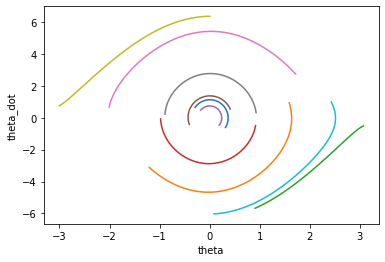

In [4]:
idx = np.random.randint(num_examples, size=10)
for i in idx:
    trajectory = data[i].T
    plt.plot(trajectory[0], trajectory[1])
    
plt.xlabel('theta')
plt.ylabel('theta_dot')

In [5]:
print(data.shape)

(15000, 100, 2)


# Recurrent neural network

In [6]:
class RecurrentNN(torch.nn.Module):
    def __init__(self, indim, hdim, outdim, num_layers, sequence_len):
        super(RecurrentNN, self).__init__()
        # print(indim, hdim, outdim, num_layers, sequence_len)
        self.indim = indim
        self.hdim = hdim
        self.outdim = outdim
        self.num_layers = num_layers
        self.sequence_len = sequence_len
        
        self.rnn = torch.nn.LSTM(self.indim, self.hdim, num_layers=self.num_layers, batch_first=True)
        self.fc = torch.nn.Linear(self.hdim, self.outdim)
    
    def forward(self, data):
        batch_size, sequence_len, indim = data.shape
        # print(batch_size, sequence_len, indim)
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hdim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hdim)
        
        # output : the output at each unrolling with shape (batch_size, sequence_len, hidden_dim)
        # hidden : the output at each layer of the final unrolling with shape (batch_size, num_layers, hidden_dim)
        outputs, _ = self.rnn(data, (h0, c0))
        final_output = outputs[:, -1, :].unsqueeze(1)
        # print(final_output.shape)
        
        prediction = self.fc(final_output)
            
        return prediction

In [7]:
rnn = RecurrentNN(indim, hdim, outdim, num_layers, sequence_len)

In [8]:
params = rnn.parameters()
num_params = np.sum([np.prod(p.shape) for p in params])
print('The number of parameters in the network is: {}'.format(num_params))

The number of parameters in the network is: 67842


In [9]:
loss_fcn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [10]:
# create dataloader
train_size = 10000
x_train_tensor = torch.Tensor(data[:train_size, :-1, :])
y_train_tensor = torch.Tensor(data[:train_size, -1, :]).unsqueeze(1)
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

x_test_tensor = torch.Tensor(data[train_size:, :-1, :])
y_test_tensor = torch.Tensor(data[train_size:, -1, :]).unsqueeze(1)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [11]:
# make weights trainable
rnn.train()

# run training loop
training_loss = train(num_epochs, print_every, trainloader, loss_fcn, optimizer, rnn)

Epoch: 0, Iteration: 0, Loss: 1.60, Acc: 0.00
Epoch: 1, Iteration: 0, Loss: 0.08, Acc: 0.00
Epoch: 2, Iteration: 0, Loss: 0.03, Acc: 0.00
Epoch: 3, Iteration: 0, Loss: 0.04, Acc: 0.00
Epoch: 4, Iteration: 0, Loss: 0.02, Acc: 0.00
Epoch: 5, Iteration: 0, Loss: 0.02, Acc: 0.00
Epoch: 6, Iteration: 0, Loss: 0.02, Acc: 0.00
Epoch: 7, Iteration: 0, Loss: 0.02, Acc: 0.00
Epoch: 8, Iteration: 0, Loss: 0.03, Acc: 0.00
Epoch: 9, Iteration: 0, Loss: 0.01, Acc: 0.00
Epoch: 10, Iteration: 0, Loss: 0.02, Acc: 0.00
Epoch: 11, Iteration: 0, Loss: 0.01, Acc: 0.00
Epoch: 12, Iteration: 0, Loss: 0.02, Acc: 0.00
Epoch: 13, Iteration: 0, Loss: 0.01, Acc: 0.00
Epoch: 14, Iteration: 0, Loss: 0.02, Acc: 0.00
Epoch: 15, Iteration: 0, Loss: 0.02, Acc: 0.00
Epoch: 16, Iteration: 0, Loss: 0.01, Acc: 0.00
Epoch: 17, Iteration: 0, Loss: 0.01, Acc: 0.00
Epoch: 18, Iteration: 0, Loss: 0.01, Acc: 0.00
Epoch: 19, Iteration: 0, Loss: 0.01, Acc: 0.00
Epoch: 20, Iteration: 0, Loss: 0.01, Acc: 0.00
Epoch: 21, Iteration: 0

Text(0, 0.5, 'L1 Loss')

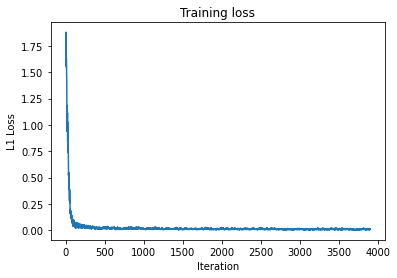

In [12]:
# plot training loss
plt.plot(training_loss)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('L1 Loss')

In [13]:
rnn.eval()

# average_accuracy, average_loss, prediction_label_data = evaluate(testloader, loss_fcn, rnn)
    
# print('Avg Loss: {loss:.2f}, Avg Acc: {acc:.2f}'.format(loss=average_loss, acc=average_accuracy))

RecurrentNN(
  (rnn): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [14]:
example_num = 0
x0 = test_dataset[example_num][0][0, :].reshape(1, 1, -1)
prediction = [x0]
hidden = (torch.zeros(rnn.num_layers, 1, rnn.hdim), torch.zeros(rnn.num_layers, 1, rnn.hdim))
for t in range(sequence_len - 1):
    output, hidden = rnn.rnn(prediction[-1], hidden)
    pred = rnn.fc(output)
    # print(x0.shape, output.shape)
    prediction.append(pred)

In [15]:
prediction_tensor = torch.cat(prediction).squeeze(1)

In [16]:
prediction_np = prediction_tensor.data.numpy()

In [17]:
print(prediction_np.shape)

(100, 2)


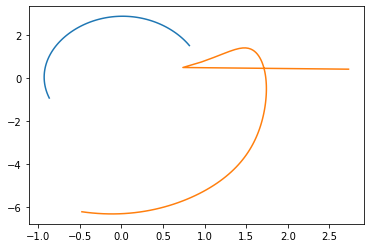

In [18]:
plt.plot(data[0][:,0], data[0][:,1])
plt.plot(prediction_np[:,0], prediction_np[:,1])

In [21]:
hidden = (torch.zeros(rnn.num_layers, 1, rnn.hdim), torch.zeros(rnn.num_layers, 1, rnn.hdim))
x = test_dataset[0][0].unsqueeze(0)
output, _ = rnn.rnn(x, hidden)
output = rnn.fc(output)
print(output.shape)

torch.Size([1, 99, 2])


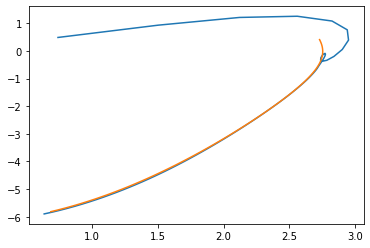

In [22]:
output_np = output.squeeze(0).data.numpy()
x_np = x.squeeze(0).data.numpy()
plt.plot(output_np[:, 0], output_np[:, 1])
plt.plot(x_np[:, 0], x_np[:, 1])

In [23]:
x_np[0], output_np[0]

(array([2.73105   , 0.40922448], dtype=float32),
 array([0.7398465 , 0.48755336], dtype=float32))

In [ ]:
# https://colah.github.io/posts/2015-08-Understanding-LSTMs/
# https://distill.pub/2016/augmented-rnns/
# Theory of gating in recurrent neural networks, Krishnamurthy et al. - https://arxiv.org/abs/2007.14823